# Task 11 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

* Task (for Lecture 11):

Change the derivative of the contractile element length function. The new function must compute the derivative according to the article from Thelen(2003) (Eq. (6) and (7)):

     Thelen D; Adjustment of muscle mechanics model parameters to simulate dynamic contractions in older adults (2003)

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### Muscle properties

In [2]:
Lslack = .223
Umax = .04
Lce_o = .093 #optmal l
width = .63#*Lce_o
Fmax = 3000
a = 1
#b = .25*10#*Lce_o 

### Initial conditions

In [3]:
Lnorm_ce = .087/Lce_o #norm
t0 = 0
tf = 2.99
h = 1e-3

In [4]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)

## Simulation - Series

for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 + .1*(t[i]-1)
        #print(Lm)
    
    #shortening at 4cm/s
    Lsee = Lm - Lce
    
    if Lsee<Lslack: 
        F[i] = 0
    else: 
        F[i] = Fmax*((Lsee-Lslack)/(Umax*Lslack))**2
        
        
    #isometric force at Lce from CE force length relationship
    F0 = max([0, Fmax*(1-((Lce-Lce_o)/width)**2)])
    
    #calculate CE velocity from Hill's equation
    if  F[i]>F0: print('Error: cannot do eccentric contractions')
    
    Lcedot = -b*(F0-F[i])/(F[i]+a) #vel is negative for shortening
    
    # --- Euler integration step
    Lce += h*Lcedot

    

In [5]:
def TendonForce (Lnorm_see,Lslack, Lce_o):
    '''
    Compute tendon force

    Inputs:
        Lnorm_see = normalized tendon length
        Lslack = slack length of the tendon (non-normalized)
        Lce_o = optimal length of the fiber
    
    Output:
        Fnorm_tendon = normalized tendon force
        
    '''
    Umax = .04
    
    if Lnorm_see<Lslack/Lce_o: 
        Fnorm_tendon = 0
    else: 
        Fnorm_tendon = ((Lnorm_see-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return Fnorm_tendon

In [6]:
def ParallelElementForce (Lnorm_ce):
    '''
    Compute parallel element force
    
    Inputs:
        Lnorm_ce = normalized contractile element length
    
    Output:
        Fnorm_kpe = normalized parallel element force

    '''
    Umax = 1
    
    if Lnorm_ce< 1: 
        Fnorm_kpe = 0
    else: 
        Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 
        
    return Fnorm_kpe

In [7]:
def ForceLengthCurve (Lnorm_ce,width):
    F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])
    return F0

def ContractileElementDot(F0, Fnorm_CE, a, b):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    if  Fnorm_CE>F0: print('Error: cannot do eccentric contractions')
    
    Lnorm_cedot = -b*(F0-Fnorm_CE)/(Fnorm_CE + a) #vel is negative for shortening
    
    return Lnorm_cedot

In [8]:
def ContractileElementDot(F0, Fnorm_CE, a):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    FMlen = 1.4 # young adults
    Vmax = 10  # young adults
    
    if  Fnorm_CE > F0:
        
        b = ((2 + 2/(F0*Lce_o))*(F0*FMlen - Fnorm_CE))/(FMlen-1)
        
    elif Fnorm_CE <= F0:
        
        b = F0 + Fnorm_CE/(F0*Lce_o)
    
    Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_CE - F0)/b)
    
    return Lnorm_cedot

In [9]:
def ContractileElementForce(Fnorm_tendon,Fnorm_kpe):
    '''
    Compute Contractile Element force

    Inputs:
        Fnorm_tendon = normalized tendon force
        Fnorm_kpe = normalized parallel element force
    
    Output:
        Fnorm_CE = normalized contractile element force
    '''
    Fnorm_CE = Fnorm_tendon - Fnorm_kpe
    return Fnorm_CE

In [10]:
def tendonLength(Lm,Lce_o,Lnorm_ce):
    '''
    Compute tendon length
    
    Inputs:
        Lm = 
        Lce_o = optimal length of the fiber
        Lnorm_ce = normalized contractile element length
    
    Output:
        Lnorm_see = normalized tendon length   
    '''
    Lnorm_see = Lm/Lce_o - Lnorm_ce
    return Lnorm_see

In [10]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:

        u = 
    
    Output:
        a =   
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
            
    da/dt = (u-a)/tau_a #resolver diferencial por euler

    return a

## Simulation - Parallel

In [11]:
#Normalizing

for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 - .04*(t[i]-1)
        #print(Lm)
    
    #shortening at 4cm/s
    
    Lnorm_see = tendonLength(Lm,Lce_o,Lnorm_ce)

    Fnorm_tendon = TendonForce (Lnorm_see,Lslack, Lce_o) 
    
    Fnorm_kpe = ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = ForceLengthCurve (Lnorm_ce,width)
    
    Fnorm_CE = ContractileElementForce(Fnorm_tendon,Fnorm_kpe) #Fnorm_CE = ~Fm
    
    #computing activation
    a = activation(a,u,dt)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = ContractileElementDot(F0, Fnorm_CE,a)
    
    # --- Euler integration step
    Lnorm_ce += h*Lnorm_cedot

    
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    

## Plots 

<IPython.core.display.Javascript object>


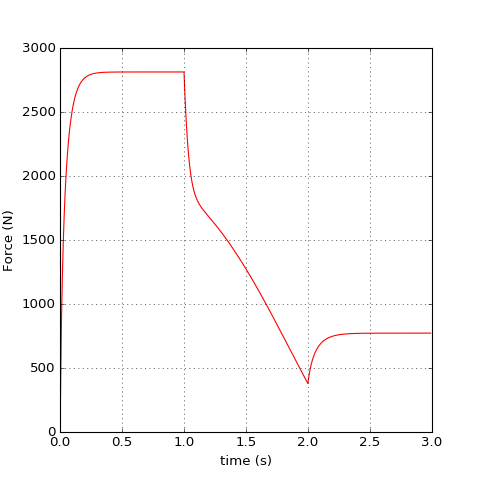

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')


ax.legend()

<IPython.core.display.Javascript object>


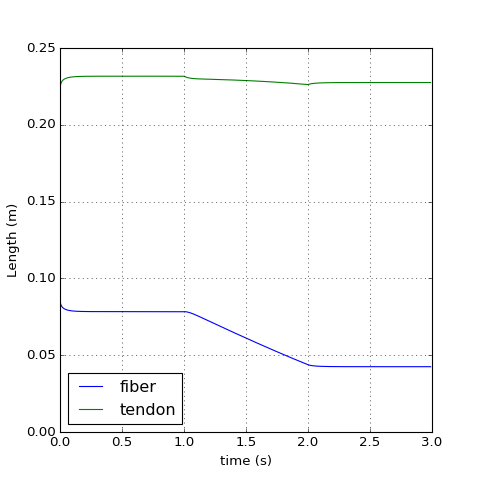

<IPython.core.display.Javascript object>


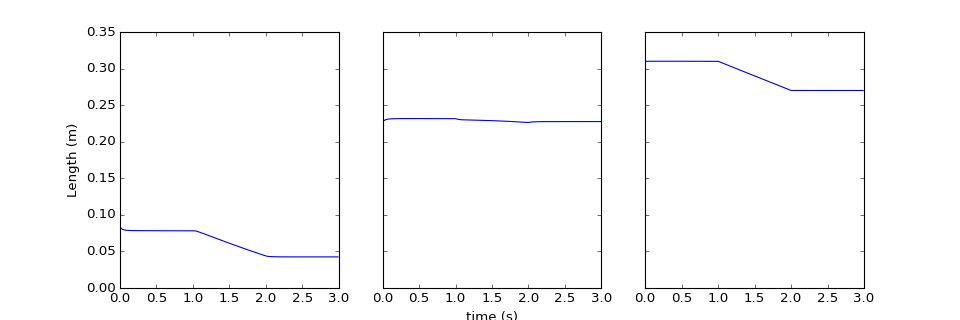

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
#plt.legend(loc='best')